Test Data Extraction from FAERs re: hypercapnia adverse effects

Taken from https://neksa.github.io/openfda-faers/OpenFDA%20API%20for%20FAERS.html 


(a larger effort for all of openfda extraction - https://github.com/FDA/openfda)


Note: I think can also download all of this in tabular format from: https://fis.fda.gov/extensions/FPD-QDE-FAERS/FPD-QDE-FAERS.html - this may be an easier approach

In [1]:
import pandas as pd
from pprint import pprint

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (4, 3)

In [3]:
import requests

# rate limiting is important to avoid accidental service abuse of the OpenFDA API provider
from ratelimit import limits, sleep_and_retry

# cache API calls in a sqllite file to reduce the number of requests to openfda server
import requests_cache
requests_cache.install_cache('openfda_cache')

# Brian key - via brian.locke@imail.org
# reference: https://open.fda.gov/apis/authentication/ 
OPENFDA_API = r"https://api.fda.gov/drug/event.json?api_key=bGkAQoWBHwOPzsYjIaTgAWH1j08mNcB7c83Moyi1&"
#OPENFDA_API = "https://api.fda.gov/drug/event.json"


@sleep_and_retry
@limits(calls=240, period=60)
def call_api(params):
    """
    OpenFDA API call. Respects rate limit. Overrides default data limit
    Input: dictionary with API parameters {search: '...', count: '...'}
    Output: nested dictionary representation of the JSON results section
    
    OpenFDA API rate limits:
         With no API key: 40 requests per minute, per IP address. 1000 requests per day, per IP address.
         With an API key: 240 requests per minute, per key. 120000 requests per day, per key.
    """

 
    if not params:
        params = {}
    params['limit'] = params.get('limit', 120000)
    response = requests.get(OPENFDA_API, params=params)
    # print(response.url)

    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    return response.json()['results']


OPENFDA_METADATA_YAML = "https://open.fda.gov/fields/drugevent.yaml"
# munch is a yaml parser with javascript-style object access
from munch import Munch

def api_meta():
    """
    YAML file with field description and other metadata retrieved from the OpenFDA website
    Parses YAML file and provides syntactic sugar for accessing nested dictionaries
    Example: .patient.properties.patientagegroup.possible_values.value
    Note: reserved words, such as count and items still have to be accessed via ['count'], ['items']
    """
    response = requests.get(OPENFDA_METADATA_YAML)
    if response.status_code != 200:
        raise Exception('Could not retrieve YAML file with drug event API fields')
    y = Munch.fromYAML(response.text)
    return y['properties']

Of note: drug and reaction columns seem particularly useful

In [4]:
api_meta().patient.properties.keys()

dict_keys(['drug', 'patientagegroup', 'patientdeath', 'patientonsetage', 'patientonsetageunit', 'patientsex', 'patientweight', 'reaction', 'summary'])

In [5]:
api_meta().patient.properties.drug['items'].properties.keys()

dict_keys(['actiondrug', 'activesubstance', 'drugadditional', 'drugadministrationroute', 'drugauthorizationnumb', 'drugbatchnumb', 'drugcharacterization', 'drugcumulativedosagenumb', 'drugcumulativedosageunit', 'drugdosageform', 'drugdosagetext', 'drugenddate', 'drugenddateformat', 'drugindication', 'drugintervaldosagedefinition', 'drugintervaldosageunitnumb', 'drugrecurreadministration', 'drugrecurrence', 'drugseparatedosagenumb', 'drugstartdate', 'drugstartdateformat', 'drugstructuredosagenumb', 'drugstructuredosageunit', 'drugtreatmentduration', 'drugtreatmentdurationunit', 'medicinalproduct', 'openfda'])

In [6]:
api_meta().patient.properties.reaction['items'].properties.keys()

dict_keys(['reactionmeddrapt', 'reactionmeddraversionpt', 'reactionoutcome'])

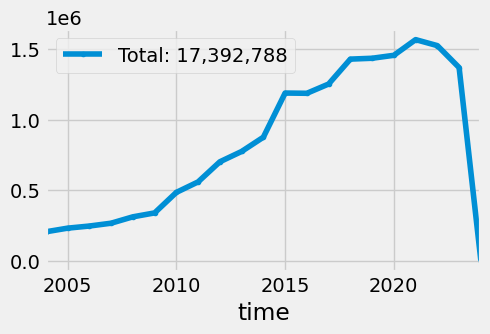

In [7]:
df = pd.DataFrame(
    call_api({
        'count':'receivedate',
        'search': 'receivedate:[20040101 TO 20240101]'}))
df.index = pd.to_datetime(df.time)
# tally reports by year
df.drop('time', axis=1).resample("y").sum().plot(style='.-', figsize=(5, 3))
total = df['count'].sum()
plt.gca().legend(["Total: {:,}".format(total)])
plt.show()

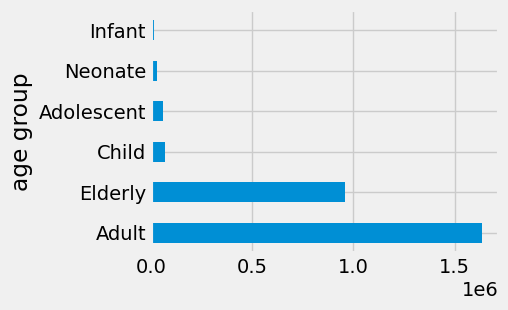

In [8]:
df = pd.DataFrame(
    call_api({
        "count": "patient.patientagegroup"}))
meta = pd.Series(
            api_meta().patient.properties.patientagegroup.possible_values.value
       ).to_frame('age group')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('age group', 'count')
plt.gca().get_legend().remove()

[ ] TODO: try restricting this to only a subtype of adverse effects that we are interested in

-- need to identify the categorizations of adverse effects - and possibly whether or not there are categories or just names.

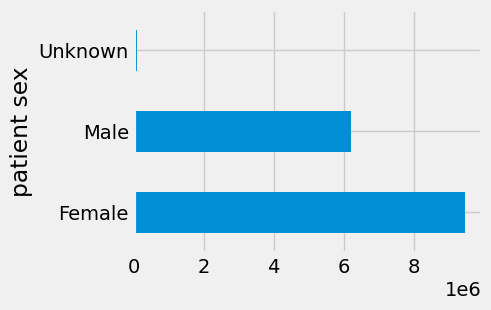

In [9]:
df = pd.DataFrame(
    call_api({
        "count": "patient.patientsex"}))
meta = pd.Series(
            api_meta().patient.properties.patientsex.possible_values.value
       ).to_frame('patient sex')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('patient sex', 'count')
plt.gca().get_legend().remove()

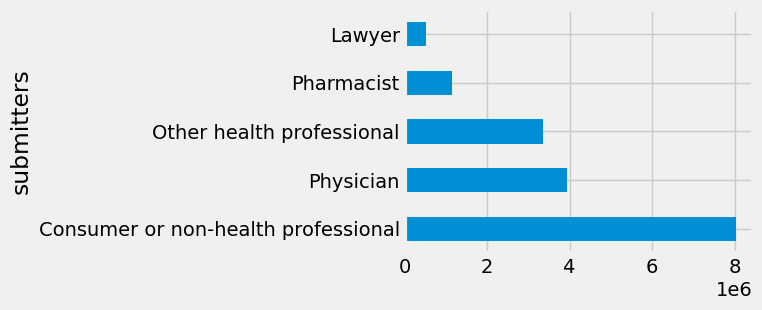

In [10]:
df = pd.DataFrame(
    call_api({"count": "primarysource.qualification"}))
meta = pd.Series(
            api_meta().primarysource.properties.qualification.possible_values.value
       ).to_frame('submitters')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('submitters', 'count')
plt.gca().get_legend().remove()
plt.show()

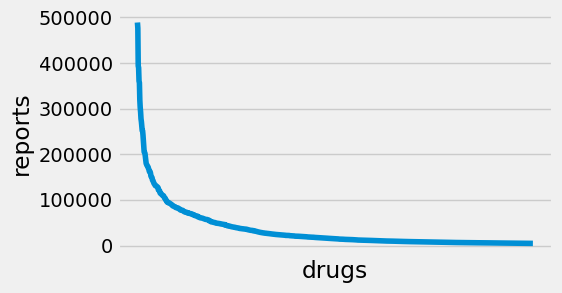

In [11]:
df = pd.DataFrame(call_api({"count": "patient.drug.activesubstance.activesubstancename.exact"}))
df.plot.line('term', 'count', figsize=(5,3))
plt.xlabel("drugs")
plt.ylabel("reports")
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().get_legend().remove()
plt.show()

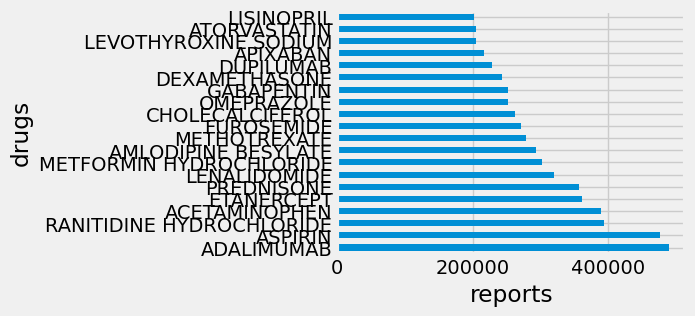

In [12]:
df[0:20].plot.barh('term', 'count')
plt.ylabel("drugs")
plt.xlabel("reports")
plt.gca().get_legend().remove()

In [13]:
from wordcloud import WordCloud

def show_wordcloud(words, background="black", color="viridis"):
    """Generate word cloud image from a dictionary of word frequencies"""
    
    # generate word cloud
    wc = WordCloud(
        background_color=background,
        max_words=200,
        max_font_size=15,
        colormap=color)
    
    image = wc.generate_from_frequencies(words)
    
    # show
    plt.figure(figsize=(10,6))
    plt.imshow(image, interpolation="bilinear")
    plt.axis("off")
    plt.show()

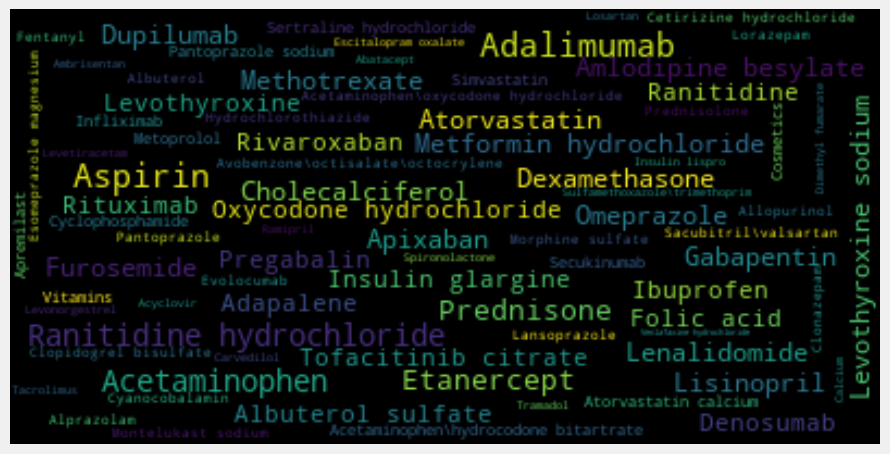

In [14]:
counts = call_api({
    "count": "patient.drug.activesubstance.activesubstancename.exact"})
words = { d['term'].capitalize(): d['count'] for d in counts }
show_wordcloud(words)

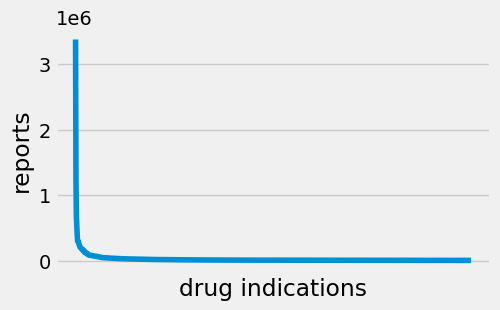

In [15]:
df = pd.DataFrame(call_api({"count": "patient.drug.drugindication.exact"}))
df.plot.line('term', 'count', figsize=(5,3))
plt.xlabel("drug indications")
plt.ylabel("reports")
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().get_legend().remove()
plt.show()

In [55]:
print(df.head())
"""
df[0:20].plot.barh('term', 'count')
plt.ylabel("drug indications")
plt.xlabel("reports")
plt.gca().get_legend().remove()

# Assuming df is your DataFrame and it has columns 'term' and 'count'
# Group by 'term' and sum the counts
term_counts = df.groupby('term')['count'].sum().reset_index()

# Sort the table by 'count' in descending order for better readability
term_counts = term_counts.sort_values(by='count', ascending=False)

# Display the table
print(term_counts)
"""

   drugrecurreadministration  count  drugcharacterization  drugadditional
0                          3  15142                     3               3
1                          2    505                     3               3
2                          1    337                     3               3


'\ndf[0:20].plot.barh(\'term\', \'count\')\nplt.ylabel("drug indications")\nplt.xlabel("reports")\nplt.gca().get_legend().remove()\n\n# Assuming df is your DataFrame and it has columns \'term\' and \'count\'\n# Group by \'term\' and sum the counts\nterm_counts = df.groupby(\'term\')[\'count\'].sum().reset_index()\n\n# Sort the table by \'count\' in descending order for better readability\nterm_counts = term_counts.sort_values(by=\'count\', ascending=False)\n\n# Display the table\nprint(term_counts)\n'

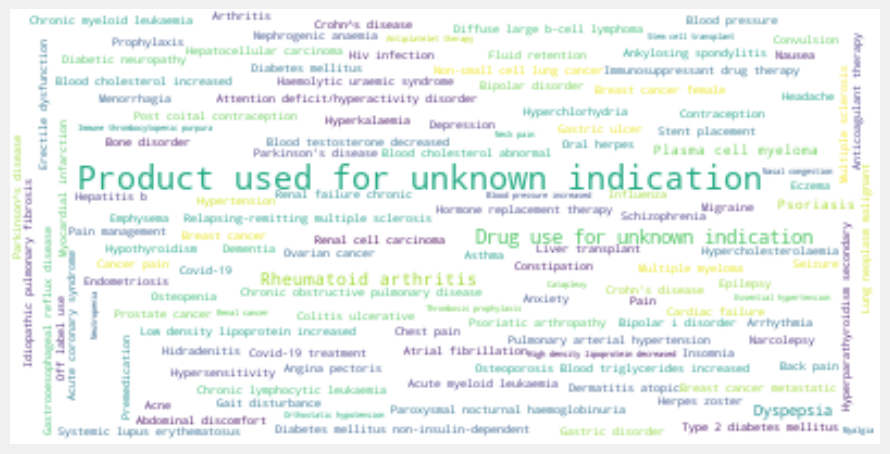

In [17]:
from itertools import islice

counts = call_api({
    "count": "patient.drug.drugindication.exact"})
words = { d['term'].capitalize(): d['count'] for d in islice(counts, 1, None) }
show_wordcloud(words, background="white")

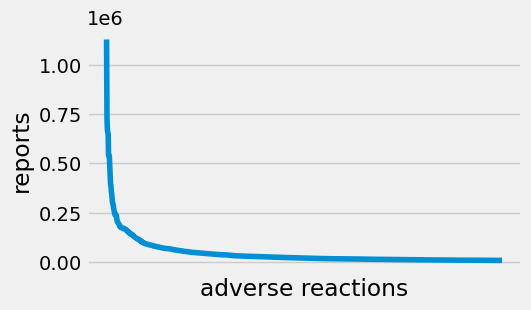

In [18]:
counts = call_api({
    "count": "patient.reaction.reactionmeddrapt.exact"})
df = pd.DataFrame(counts)

df.plot.line('term', 'count', figsize=(5,3))
plt.xlabel("adverse reactions")
plt.ylabel("reports")
plt.gca().axes.get_xaxis().set_ticks([])
plt.gca().get_legend().remove()
plt.show()

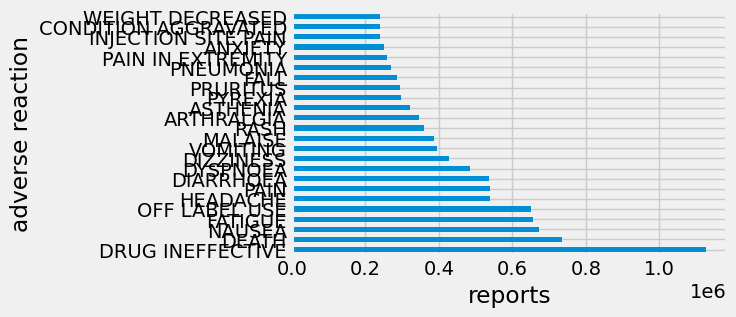

In [19]:
df[0:24].plot.barh('term', 'count', figsize=(5, 3))
plt.gca().get_legend().remove()
plt.xlabel("reports")
plt.ylabel("adverse reaction")
plt.show()

In [20]:
print(len(df['term'].to_list()))

1000


TODO: list all of the adverse reactions to find ones that seem hypercapnia related.

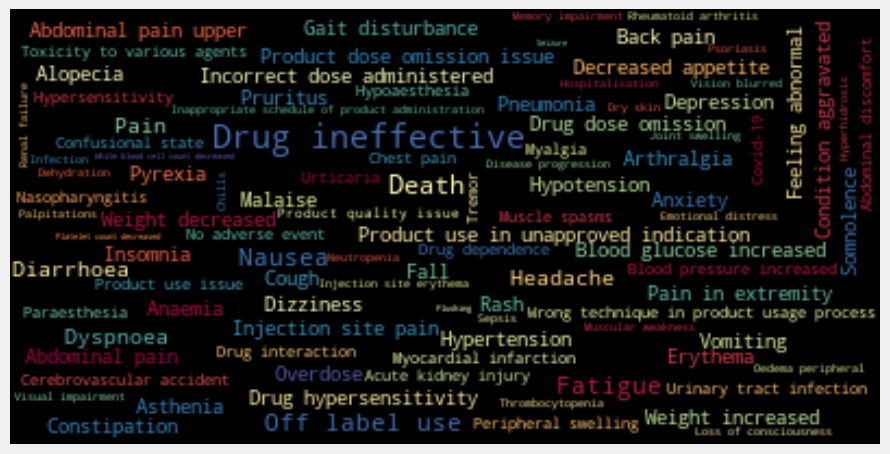

In [21]:
words = { d['term'].capitalize(): d['count'] for d in counts }
show_wordcloud(words, background="black", color="Spectral")

In [22]:
def get_trend_for_reaction(reaction):
    """Returns dataframe with yearly tally of event reports for a given reaction"""
    df = pd.DataFrame(
        call_api({
            'count':'receivedate',
            'search': "receivedate:[20040101 TO 20200101] AND patient.reaction.reactionmeddrapt.exact: {}".format(
                reaction.upper()
            )}))
    df.index = pd.to_datetime(df.time)
    df = df.drop('time', axis=1).resample("y").sum().rename(
        columns={"count": reaction.capitalize()})
    return df

[ ] TODO: get respiratory-related complciations

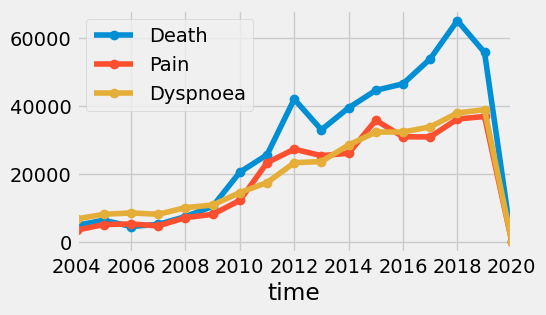

In [23]:
reactions = ['death', 'pain', 'dyspnoea']
df = pd.concat([get_trend_for_reaction(x) for x in reactions], axis=1)
df.plot(style='o-', figsize=(5, 3))
plt.show()

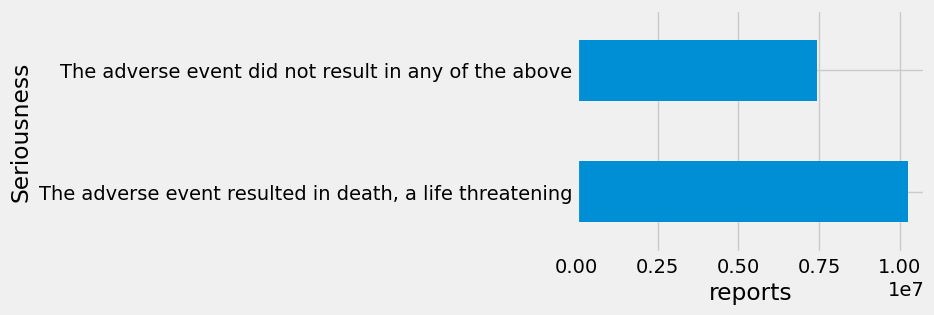

In [24]:
df = pd.DataFrame(call_api({"count": "serious"}))
meta = pd.Series(
            api_meta().serious.possible_values.value
       ).to_frame('Seriousness')
meta['term'] = meta.index.astype(int)
meta['Seriousness'] = list(map(lambda x: x[0:55], meta['Seriousness']))

df.merge(meta, on='term').plot.barh('Seriousness', 'count')
plt.xlabel("reports")
plt.gca().get_legend().remove()
plt.show()

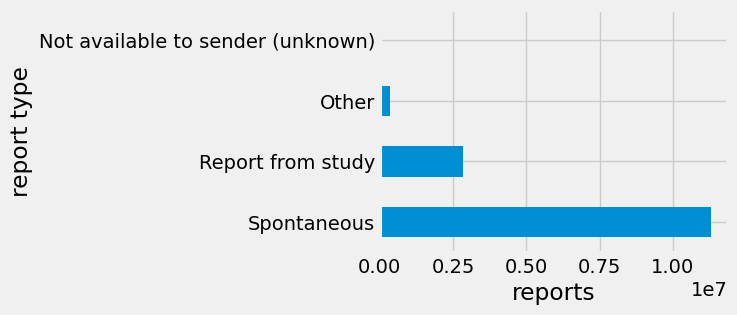

In [25]:
df = pd.DataFrame(call_api({"count": "reporttype"}))
meta = pd.Series(
            api_meta().reporttype.possible_values.value
       ).to_frame('report type')
meta['term'] = meta.index.astype(int)
df.merge(meta, on='term').plot.barh('report type', 'count')
plt.xlabel("reports")
plt.gca().get_legend().remove()
plt.show()

In [26]:
api_meta().patient.properties.drug['items'].properties.drugcharacterization.description

'Reported role of the drug in the adverse event report. These values are not validated by FDA.'

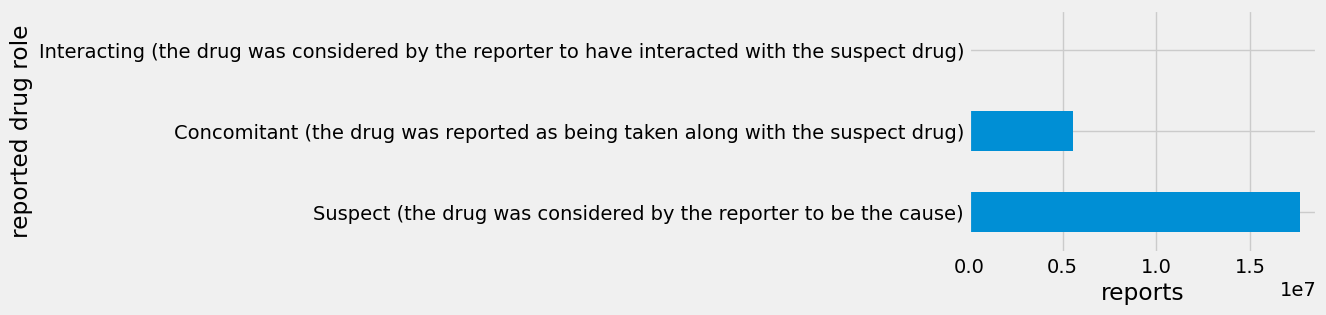

In [27]:
df = pd.DataFrame(call_api({
    "count": "patient.drug.drugcharacterization",
    }))

meta = pd.Series(
            api_meta().patient.properties.drug['items'].properties.drugcharacterization.possible_values.value
       ).to_frame('reported drug role')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('reported drug role', 'count')
plt.xlabel("reports")
plt.gca().get_legend().remove()
plt.show()

interestingly, the drugadditional field contains information on what happens with rechallenge. 

In [28]:
api_meta().patient.properties.drug['items'].properties.drugadditional.description

'Dechallenge outcome information—whether the event abated after product use stopped or the dose was reduced. Only present when this was attempted and the data was provided.'

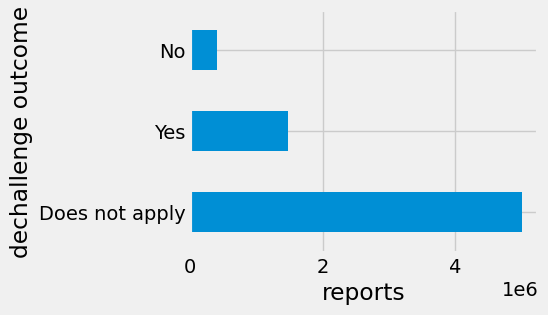

In [29]:
df = pd.DataFrame(call_api({
    "count": "patient.drug.drugadditional",
    }))
# 'search': "patient.drug.drugindication.exact: HYPERTENSION"

meta = pd.Series(
            api_meta().patient.properties.drug['items'].properties.drugadditional.possible_values.value
       ).to_frame('dechallenge outcome')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('dechallenge outcome', 'count')
plt.gca().get_legend().remove()
plt.xlabel("reports")
plt.show()

In [30]:
api_meta().patient.properties.drug['items'].properties.drugrecurreadministration.description

'Whether the reaction occured after readministration of the drug.'

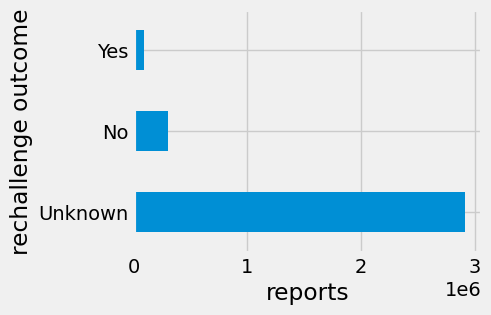

In [31]:
df = pd.DataFrame(call_api({
    "count": "patient.drug.drugrecurreadministration",
    }))
# 'search': "patient.drug.drugindication.exact: HYPERTENSION"

meta = pd.Series(
            api_meta().patient.properties.drug['items'].properties.drugrecurreadministration.possible_values.value
       ).to_frame('rechallenge outcome')
meta['term'] = meta.index.astype(int)

df.merge(meta, on='term').plot.barh('rechallenge outcome', 'count')
plt.gca().get_legend().remove()
plt.xlabel("reports")
plt.show()

In [32]:
from itertools import product

df_all = pd.DataFrame()
for drugcharacterization, drugadditional in product((1,2,3), (1,2,3)):
    df = pd.DataFrame(call_api({
        "count": "patient.drug.drugrecurreadministration",
        'search': "patient.drug.drugcharacterization: {} AND patient.drug.drugadditional: {}".format(
        drugcharacterization, drugadditional)
    }))
    df['drugcharacterization'] = drugcharacterization
    df['drugadditional'] = drugadditional
    df = df.rename(columns={'term': 'drugrecurreadministration'})
    df_all = pd.concat([df_all, df])

df_all = df_all.reset_index(drop=True)

In [33]:
df_all['prob'] = df_all.groupby(
         ["drugcharacterization", "drugadditional"]
     )['count'].transform(
         lambda x: x / x.sum())
df_all

df_all['joint_prob'] = df_all['count'] / df_all['count'].sum()
df_all.head()

,drugrecurreadministration,count,drugcharacterization,drugadditional,prob,joint_prob
0,3,315574,1,1,0.736694,0.116291
1,2,68101,1,1,0.158979,0.025096
2,1,44690,1,1,0.104327,0.016469
3,3,71199,1,2,0.720791,0.026237
4,2,15287,1,2,0.154760,0.005633


not sure I understand what the drugcharacterization represents... the occurence per individual?

In [34]:
df_all.groupby(["drugcharacterization"])['count', ].sum() / df_all['count'].sum()

,count
drugcharacterization,
1,0.733354
2,0.255968
3,0.010679


In [35]:
# Joint probability of suspect drug that also passed dechallenge and rechallenge tests:

float(df_all[
    (df_all.drugcharacterization == 1) &
    (df_all.drugadditional == 1) &
    (df_all.drugrecurreadministration == 1)].joint_prob)

/var/folders/vf/n84t7b8171lf64smq4ddvw1m0000gn/T/ipykernel_19169/4189630193.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(df_all[


0.016468593960164354

todo: can modify this to seek other conditions. [ ] need to find the classification of indications


In [37]:
from tqdm import tqdm

adr = []

# load only the first 100 pages by 1000 reports = 100,000 events
# HYPERTENSION? - could you do for other indications. 
for page in tqdm(range(100)):
    try:
        d = call_api({
            'search':
                "patient.drug.drugcharacterization: {} AND "
                "patient.drug.drugadditional: {} AND "
                "patient.drug.drugrecurreadministration: {} "
                "patient.drug.drugindication.exact:{} AND "
                "serious: {} AND "
                "reporttype: {} "
                "".format(1, 1, 1, "HYPERTENSION", 2, 1),
            'limit': 1000,
            'skip': page
        })
    except:
        raise
        break
    adr += d

"Total ADR events loaded", len(adr)

100%|██████████| 100/100 [07:14<00:00,  4.34s/it]


('Total ADR events loaded', 41850)

In [38]:
drugs_adr_list = []

for event in adr:
    # There is no way to determine what drug caused what reaction from the report
    # Thus, we consider all combinations
    for d in event['patient']['drug']:
        if not d.get('activesubstance'):
            continue
        drug = d['activesubstance']['activesubstancename'] 
        for r in event['patient']['reaction']:
            reaction = r.get('reactionmeddrapt')
            drugs_adr_list.append({
                'drug': drug,
                'adr': reaction,
            })

drugs_adr_df = pd.DataFrame(drugs_adr_list)
drugs_adr_df.head(n=100)

,drug,adr
0,AMLODIPINE BESYLATE,Muscle spasms
1,AMLODIPINE BESYLATE,Asthenia
2,AMLODIPINE BESYLATE,Gait disturbance
3,BUSPIRONE HYDROCHLORIDE,Chest pain
4,FLUOXETINE\FLUOXETINE HYDROCHLORIDE,Chest pain
...,...,...
95,IRBESARTAN,Abdominal pain upper
96,IRBESARTAN,Sleep disorder
97,IRBESARTAN,Product quality issue
98,LOSARTAN,Dizziness


In [39]:
drugs_adr = pd.crosstab(drugs_adr_df.drug, drugs_adr_df.adr)
drugs_adr

adr,Abdominal discomfort,Abdominal distension,Abdominal pain,Abdominal pain lower,Abdominal pain upper,Abnormal behaviour,Abnormal dreams,Accidental exposure to product,Activities of daily living impaired,Acute kidney injury,...,Vulvovaginal burning sensation,Weight decreased,Weight increased,Wheezing,White blood cell count increased,Withdrawal syndrome,Wound,Wrong product administered,Wrong technique in device usage process,Wrong technique in product usage process
drug,,,,,,,,,,,,,,,,,,,,,
.ALPHA.-LIPOIC ACID,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.ALPHA.-TOCOPHEROL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
".ALPHA.-TOCOPHEROL ACETATE, DL-\ASCORBIC ACID\CYANOCOBALAMIN\FLUORIDE ION\FOLIC ACID\NIACIN\PYRIDOXINE\RIBOFLAVIN\THIAMINE\VITAMIN A\VITAMIN D",0,0,0,0,0,0,0,0,0,0,...,0,0,54,54,0,0,0,0,0,0
ABIRATERONE ACETATE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACARBOSE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZINC OXIDE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZOLEDRONIC ACID,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZOLPIDEM TARTRATE,0,100,100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/Users/blocke/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/blocke/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


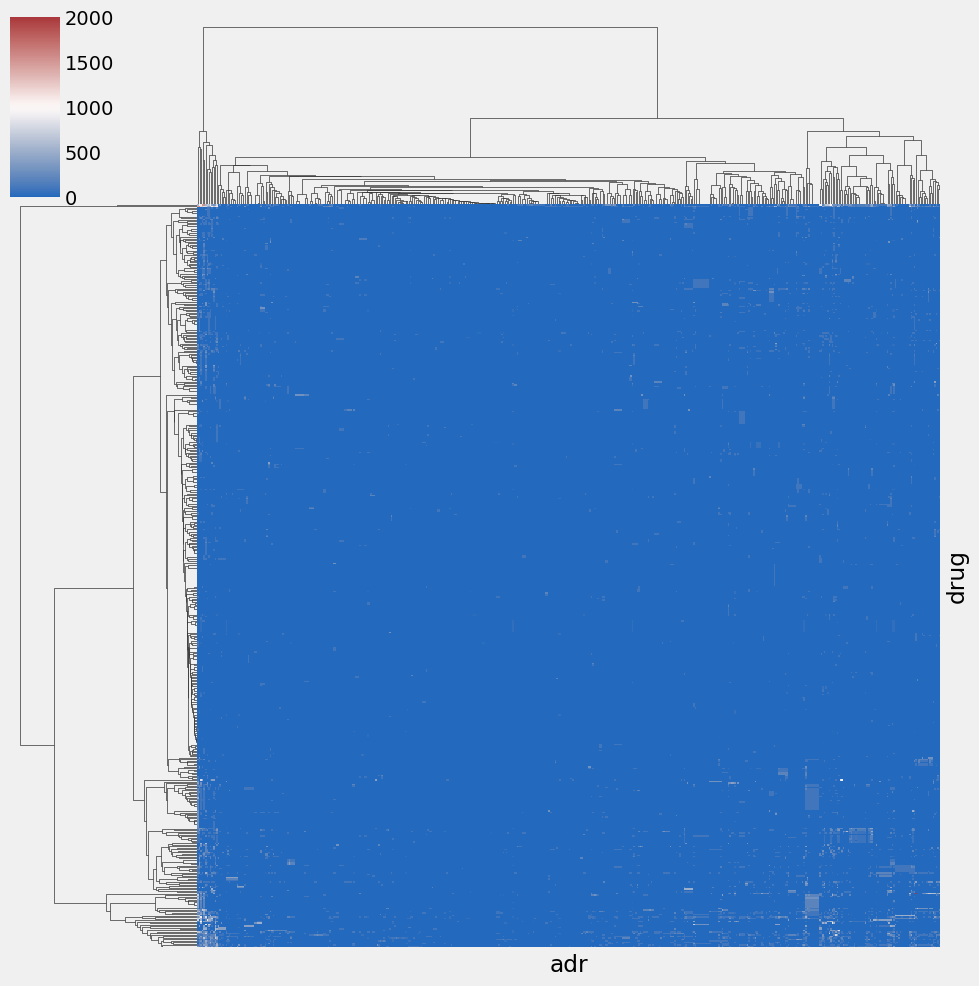

In [40]:
import seaborn as sns
 
# drugs_adr.div(drugs_adr.sum(axis=1), axis=0)
# standard_scale=1, 
g = sns.clustermap(drugs_adr, cbar=True, method='ward', cmap="vlag", xticklabels=False, yticklabels=False)


In [41]:
# retrieve top left quadrant: - not sure I understand what the numbers represent....
drugs_adr.iloc[
    g.dendrogram_row.reordered_ind[0:50],
    g.dendrogram_col.reordered_ind[0:50]]

adr,Rash,Drug ineffective,Headache,Blood pressure increased,Dizziness,Diarrhoea,Fatigue,Asthenia,Feeling abnormal,Cough,...,Vision blurred,Mydriasis,Product colour issue,Irritability,Therapeutic product effect incomplete,Throat irritation,Expired product administered,Heart rate irregular,Feeling jittery,Oropharyngeal pain
drug,,,,,,,,,,,,,,,,,,,,,
AMLODIPINE BESYLATE,548,1047,1097,1503,1553,567,700,609,900,400,...,100,0,0,0,100,100,200,0,200,100
LISINOPRIL,1456,1548,1200,700,800,768,500,400,577,1100,...,300,0,50,100,0,0,100,100,100,0
FLUTICASONE PROPIONATE,0,0,0,45,0,0,100,100,0,100,...,0,0,0,45,0,200,0,0,0,0
MELATONIN,0,0,0,0,0,200,100,100,0,0,...,0,0,0,0,0,0,0,0,0,0
POTASSIUM GLUCONATE,0,0,0,0,0,0,100,100,0,0,...,0,0,0,0,0,0,0,0,0,0
QUINAPRIL HYDROCHLORIDE,0,0,0,0,0,0,100,100,0,0,...,0,0,0,0,0,0,0,0,0,0
GUANFACINE,0,0,0,0,0,0,100,100,0,0,...,0,0,0,0,0,0,0,0,0,0
NITROFURANTOIN\NITROFURANTOIN MONOHYDRATE,0,0,0,0,0,0,100,100,0,0,...,0,0,0,0,0,0,0,0,0,0
CYANOCOBALAMIN\DEXPANTHENOL\NIACINAMIDE\PYRIDOXINE HYDROCHLORIDE\RIBOFLAVIN 5^-PHOSPHATE SODIUM\THIAMINE HYDROCHLORIDE\VITAMIN B COMPLEX,0,100,0,200,100,0,0,100,0,0,...,0,0,0,0,0,0,0,0,0,0


Here, Lenalidomide and Lisinopril have similar profiles on the clustergram. They all seem to be related to disturbance of attention, asthenia, fatigue and feeling abnormal, as well as rash and headache.

Lenalidomide is a chemotherapy drug that can treat myelodysplastic syndrome (MDS), multiple myeloma, and mantle cell lymphoma (MCL) (according to First Databank).

Whereas Lisinopril is an ACE inhibitor that can treat high blood pressure and heart failure. It can also reduce the risk of death after a heart attack (according to First Databank).

Without using any statistical approach is difficult to assess whether in any specific condition there is a disproportionality in association between a drug and an adverse reaction.

A quick literature search revealed a paper comparing several quantitative tests:

"A comparison of measures of disproportionality for signal detection in spontaneous reporting systems for adverse drug reactions" van Puijenbroek et al. Pharmacoepidemiology and Drug Safety, 2002; 11: 3–10

Below I implemented two tests:

Test: Reporting Odds Ratio (ROR) 􏰀- 1.96 SE > 1
Test: proportional reporting ratio (PRR) 􏰀- 1.96 SE > 1
Reporting Odds ratio is a measure of disproportionality in case/non-case approach.

In PRR Adverse event is reported for patients taking specific drug compared to the frequency at which the same adverse event is reported for patients taking some other drug.

“A PRR greater than 1 suggests that the adverse event is more commonly reported for individuals taking the drug of interest, relative to the comparison drugs. This could indicate that the adverse event is caused by the drug of interest and therefore a "side effect", although a PRR exceeding 1 could also reflect sampling variation in the data, reporting errors, biased reporting, multiple reports of the same case or the same patient, or a number of other causes.”


The calculations are based on a contingency table, which in turn is using the drug-ADR matrix.

From the contingency table an odds ratio or reporting ratio statistic is calculated. We further assess the bottom bracket of the 95% confidence interval, calculated using standard error. If the value is above 1 then we have detected disproportionality.

I have not evaluated statistical significance of ROR or PRR, however it can be avaluated using Fisher exact test, for instance, as suggested in the paper cited above.

In case of multiple testing, when testing each represented drug-ADR combination, a multiple testing correction like Bonferroni or Benjamini-Hochberg has to be applied to correct the p-values.

I also created simple unit tests to check that ROR and PRR functions work as expected. However, the tests are not comprehensive.


In [42]:
import numpy as np

def make_contingency_table(drugs_adr, drug, adr):
    """ 
        Contingency table:

        a = Reports with the suspected drug and suspected ADR
        b = Reports with the suspected drug and without the suspected ADR

        c = All other reports with the suspected ADR
        d = All other reports without the suspected ADR    
    """
    a = drugs_adr.loc[drug, adr]
    b = drugs_adr.loc[drug, :].sum() - a
    c = drugs_adr.loc[:, adr].sum() - a
    d = drugs_adr.sum().sum() - a - b - c
    return a, b, c, d


def ROR_test(contingency_table):
    """
    Reporting odds ratio test
    
    Stricker BHCh, Tijssen JGP. Serum sickness-like reactions to cefaclor. J Clin Epidemiol 1992; 45: 1177–1184.
    """
    a, b, c, d = contingency_table
    # none of the values is allowed to be zero
    assert a * b * c * d > 0
    ror = (a*d) / (b*c)
    se_lnror = np.sqrt(1/a + 1/b + 1/c + 1/d)
    # 95% CI
    return np.round(
        np.exp(np.log(ror) - 1.96*se_lnror), 4)



def PRR_test(contingency_table):
    """
    Proportional ADR reporting ratio (PRR)
    
    Greenland S, Rothman KJ. Introduction to categorical statistics. Greenland S, Rothman KJ (eds). In Modern Epidemiology (2nd
edn), Lippincott-Raven: Philadelphia, 2001; 231–252.
    """
    a, b, c, d = contingency_table
    # a or c are not allowed to be zero
    assert a * c > 0
    prr = (a / (a + b))  / (c / (c + d)) 
    se_lnprr = np.sqrt(1/a - 1/(a+b) + 1/c + 1/(c+d))
    return np.round(
        np.exp(np.log(prr) - 1.96*se_lnprr), 4)


def unit_tests():
    """ This is just an example of unit tests, checking for output sanity """
    assert ROR_test((1,1,1,1)) < 1.0
    assert PRR_test((1,1,1,1)) < 1.0
    
    assert ROR_test((5,1,50,100)) > 1.0
    assert PRR_test((5,1,50,100)) > 1.0

    print("Tests passed")


unit_tests()

Tests passed


In [43]:
contingency_table = make_contingency_table(drugs_adr, "AMLODIPINE BESYLATE", "Headache")
print(contingency_table)
print("ROR > 1:", ROR_test(contingency_table))
print("PRR > 1:", PRR_test(contingency_table))

(1097, 38012, 25117, 917086)
ROR > 1: 0.9911
PRR > 1: 0.9913


In [44]:
contingency_table = make_contingency_table(drugs_adr, "NEBIVOLOL HYDROCHLORIDE", "Feeling abnormal")
print(contingency_table)
print("ROR > 1:", ROR_test(contingency_table))
print("PRR > 1:", PRR_test(contingency_table))

(77, 5963, 13673, 961599)
ROR > 1: 0.7249
PRR > 1: 0.7279


ROR and PRR statistics are quite similar. Also, I believe they are designed to handle comparisons with much lower counts than we have in the drug-ADR matrix.

These tests are just a demonstration of the approach that could be taken to analyze drug-ADR relationships further.

In [45]:
import umap

# Fix the random state for reproducibility
embedding = umap.UMAP(random_state=42).fit_transform(drugs_adr)

/Users/blocke/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [46]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=2).fit(embedding)
labels = clustering.labels_

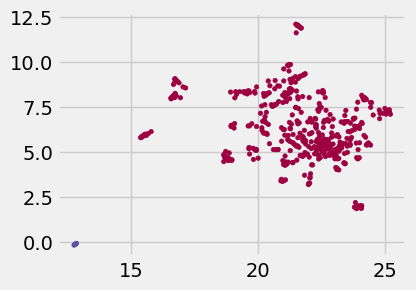

In [47]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, c=labels, cmap='Spectral')